# F10.7
ftp://ftp.geolab.nrcan.gc.ca/data/solar_flux/daily_flux_values/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

3개의 파일로부터 F10.7 Data를 읽어 옵니다.
* 1개의 값이 있는 날도,
* 3개의 값이 있는 날도,
* 값이 없는 날도 있습니다.

In [2]:
df_F107_1947_1996 = pd.read_csv('./F107_1947_1996.txt', skiprows=3, names=['Julian Date', 'Rotation', 'year', 'mo', 'dy', 'Obs.', 'Adj.', 'URSI-D'], index_col='Julian Date')
df_F107_1996_2007 = pd.read_csv('./F107_1996_2007.txt', skiprows=3, delim_whitespace=True, names=['Julian Date', 'Rotation', 'year', 'mo', 'dy', 'Time', 'Obs.', 'Adj.', 'URSI-D'], index_col='Julian Date')
df_F107_2004 = pd.read_csv('./fluxtable.txt', skiprows=2, delim_whitespace=True, names=['Date', 'Time', 'Julian Date', 'Rotation', 'Obs.', 'Adj.', 'URSI-D'], index_col='Julian Date')

자료들을 하나의 Serise로 만듭니다.
* Julian date를 기준으로 하여 통합후, `datetime`으로 변환 합니다.

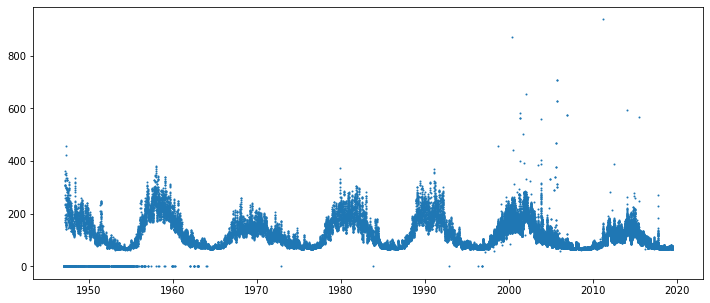

In [3]:
serise_F107 = pd.concat([df_F107_1947_1996['Obs.'], df_F107_1996_2007['Obs.'], df_F107_2004['Obs.']])
serise_F107.index = pd.DatetimeIndex(serise_F107.index.map(lambda j: pd.to_datetime(j, unit='D', origin='julian').ceil('H')), name='Date')

plt.figure(figsize=(12,5))
plt.scatter(serise_F107.index, serise_F107, s=1)
plt.show()

## F10.7 Daily Data
`serise_F107` 로부터 매일의 F10.7 값들을 평균하여 Daily data를 만듭니다.
* 1개의 값이 있는 날의 경우 그 값을 선택,
* 3개의 값이 있는 날의 경우 세 값을 평균,
* 0개의 값이 있는 날의 경우 선형보간
합니다.

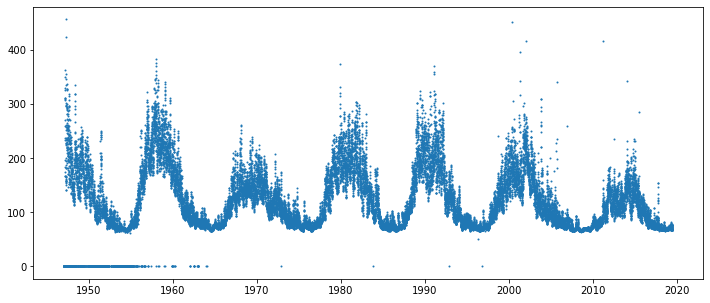

In [4]:
F107_Daily = serise_F107.resample('1D').mean()
F107_Daily = F107_Daily.interpolate()

plt.figure(figsize=(12,5))
plt.scatter(F107_Daily.index, F107_Daily, s=1)
plt.show()

## F10.7 Weekly Data
`serise_F107` 로부터 한 주의 값들을 평균하여 Weekly data를 만듭니다.

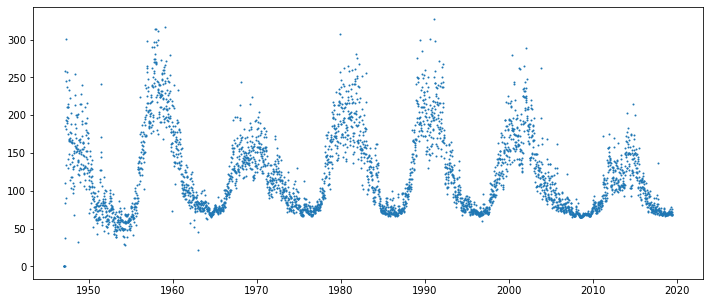

In [5]:
F107_Weekly = serise_F107.resample('1W').mean()

plt.figure(figsize=(12,5))
plt.scatter(F107_Weekly.index, F107_Weekly, s=1)
plt.show()

## F10.7 Monthly Data
`F107_Weekly` 로부터 한 달의 값들중 최대값을 택하여 Monthly data를 만듭니다.

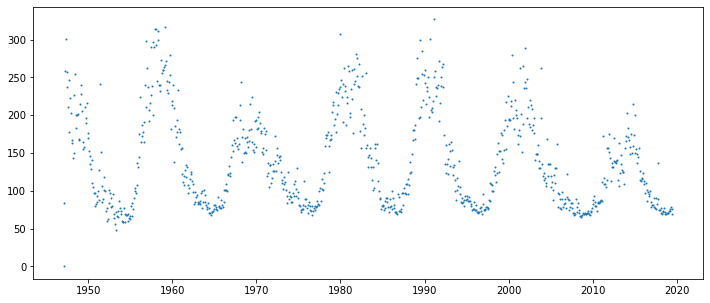

In [6]:
F107_Monthly = F107_Weekly.resample('1M').max()

plt.figure(figsize=(12,5))
plt.scatter(F107_Monthly.index, F107_Monthly, s=1)
plt.show()

## F10.7a (81일 평균) Data
`F107_Daily` 로부터 81일 평균 데이터를 만듭니다.

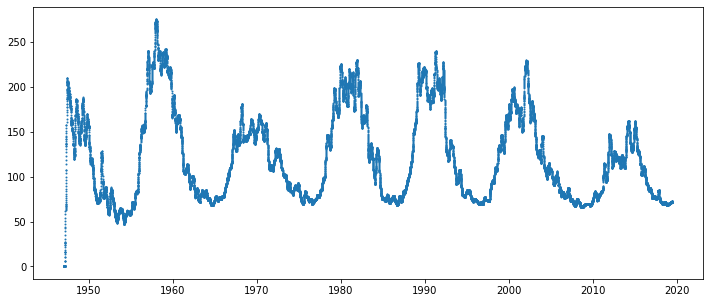

In [7]:
F107_81a = F107_Daily.rolling('81D').mean()

plt.figure(figsize=(12,5))
plt.scatter(F107_81a.index, F107_81a, s=1)
plt.show()

# Ap
http://wdc.kugi.kyoto-u.ac.jp/kp/index.html

In [8]:
df_Ap = pd.read_fwf('./Kp index.txt', widths=[9,16,3,24,3], skiprows=1, names=['Date', 'Kp[8]', 'Sum', 'ap[8]', 'Ap'], index_col='Date')
df_Ap.index = pd.DatetimeIndex(df_Ap.index.map(str))

## Ap Daily Data

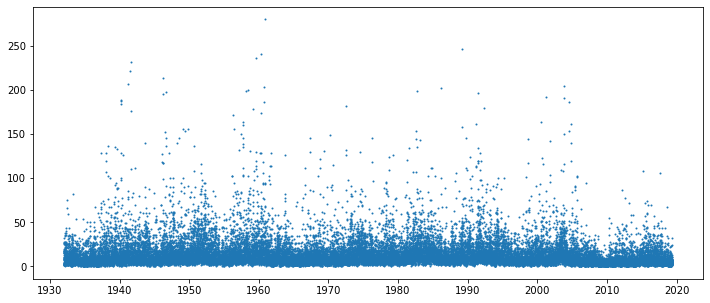

In [9]:
Ap_Daily = df_Ap['Ap']

plt.figure(figsize=(12,5))
plt.scatter(Ap_Daily.index, Ap_Daily, s=1)
plt.show()

## Ap Weekly Data

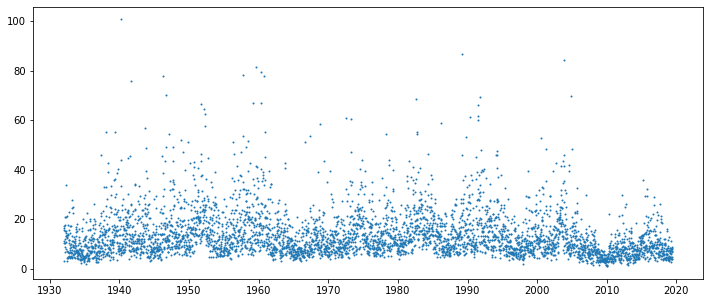

In [10]:
Ap_Weekly = Ap_Daily.resample('1W').mean()

plt.figure(figsize=(12,5))
plt.scatter(Ap_Weekly.index, Ap_Weekly, s=1)
plt.show()

## Ap Monthly Data

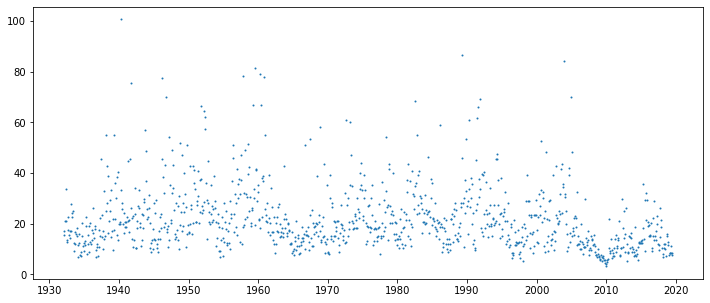

In [11]:
Ap_Monthly = Ap_Weekly.resample('1M').max()

plt.figure(figsize=(12,5))
plt.scatter(Ap_Monthly.index, Ap_Monthly, s=1)
plt.show()

# NRLMSISE-00 Atmosphere Model
https://github.com/space-physics/msise00

대전 지역 200km 상공의 ATOX density를 구하는 함수의 예시입니다.

In [12]:
import msise00
from tqdm import tqdm
from datetime import datetime

def OX_density(t):
    date = pd.to_datetime(t).floor('D')
    density = msise00.run(time=t,
                          altkm=500.0,
                          glat=36.3504, glon=127.3845,   # 대전
                          f107a=float(F107_81a[date]),
                          f107=float(F107_Daily[date]),
                          Ap=int(Ap_Daily[date])
                         )['O']
    return float(density)

하루에 8번 ATOX density를 구하고 그중 가장 큰값을 그날의 ATOX density로 정합니다.
* 30분정도 소요됩니다.

In [13]:
idx = pd.DatetimeIndex(pd.date_range('1948-01-01', '2019-05-31', freq='3H'))
d = [OX_density(t) for t in tqdm(idx)]
series_ATOX = pd.Series(d, idx)
series_ATOX.to_csv('./ATOX_density(msise00).csv')

100%|██████████| 208665/208665 [32:52<00:00, 105.79it/s]
/Users/wizard/miniconda3/envs/ATOX/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


* 설정을 바꾸지 않는다면, 저장된 데이터를 사용하셔도 됩니다.

In [14]:
ATOX_Daily = pd.Series.from_csv('./ATOX_density(msise00).csv')

/Users/wizard/miniconda3/envs/ATOX/lib/python3.7/site-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


## ATOX Density Daily Data

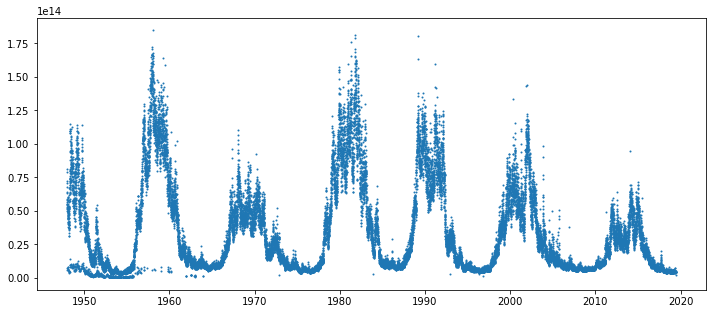

In [15]:
ATOX_Daily = series_ATOX.resample('1D').max()

plt.figure(figsize=(12,5))
plt.scatter(ATOX_Daily.index, ATOX_Daily, s=1)
plt.show()

## ATOX Density Weekly Data

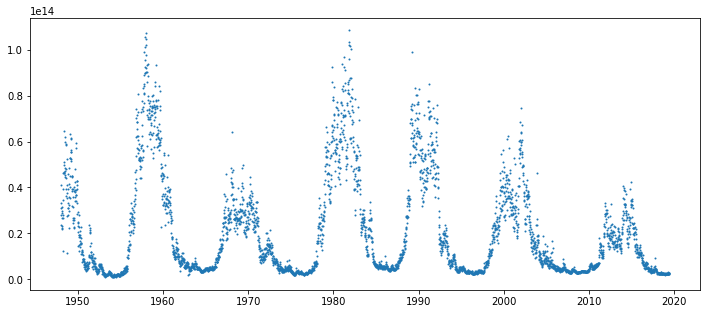

In [16]:
ATOX_Weekly = series_ATOX.resample('1W').mean()

plt.figure(figsize=(12,5))
plt.scatter(ATOX_Weekly.index, ATOX_Weekly, s=1)
plt.show()

## ATOX Density Monthly Data

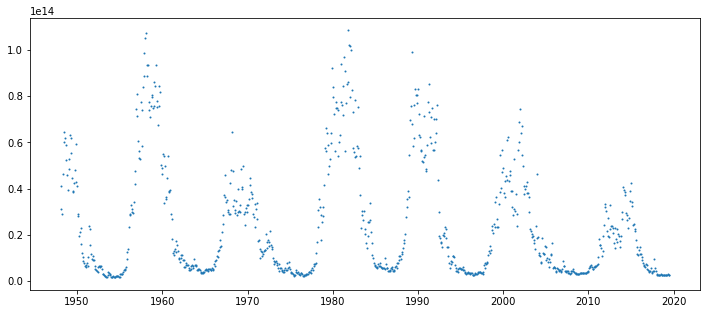

In [17]:
ATOX_Monthly = ATOX_Weekly.resample('1M').max()

plt.figure(figsize=(12,5))
plt.scatter(ATOX_Monthly.index, ATOX_Monthly, s=1)
plt.show()